In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

from model import UNet
from data_utils import SegmentationDataset


/home/archimickey/mambaforge/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LightningUNet(pl.LightningModule):
    def __init__(self, batch_size=1, lr=1e-4, num_workers=12, **kwargs):
        super().__init__()
        self.batch_size = batch_size
        self.lr = lr
        self.num_workers = num_workers
        self.model = UNet(n_channels=3, n_classes=21)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=255)
    
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(self.device)
        mask = mask.to(self.device).long()
        
        logits = self.model(img)
        
        loss = self.loss_fn(logits, mask)
        self.log('train/loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(self.device)
        mask = mask.to(self.device).long()
        
        logits = self.model(img)
        
        loss = self.loss_fn(logits, mask)
        self.log('val/loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        ds = SegmentationDataset()
        return DataLoader(ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
    
    def val_dataloader(self):
        ds = SegmentationDataset(image_set='val')
        return DataLoader(ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

In [5]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

pl.seed_everything(42)
trainer = Trainer(devices=1, accelerator='gpu', max_epochs=100, check_val_every_n_epoch=10)
cfg = {
    'batch_size': 16,
    'lr': 1e-4,
}
model = LightningUNet(**cfg)
trainer.fit(model=model)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 31.0 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.156   Total estimated model params size (MB)


Epoch 99: 100%|██████████| 183/183 [00:19<00:00,  9.31it/s, loss=0.0874, v_num=8]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 183/183 [00:19<00:00,  9.30it/s, loss=0.0874, v_num=8]


  1%|          | 1/92 [00:01<03:00,  1.99s/it]

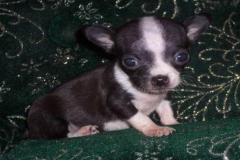

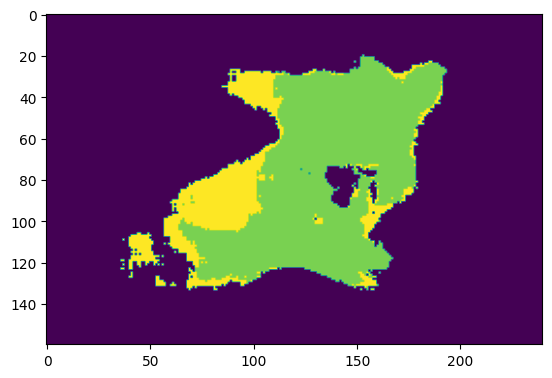

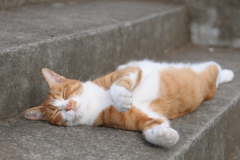

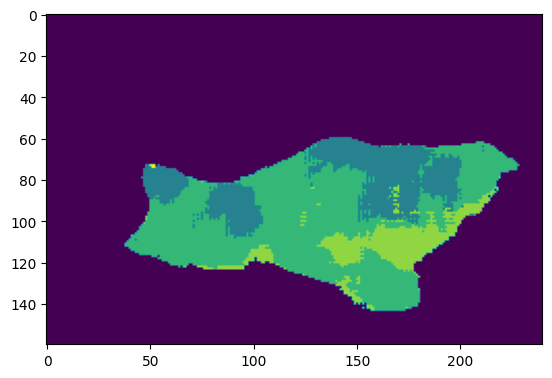

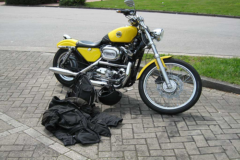

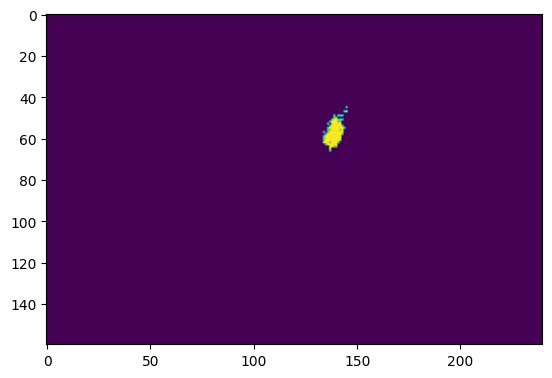

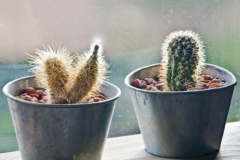

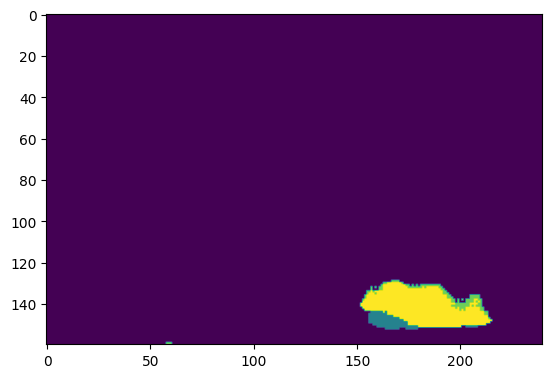

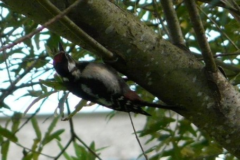

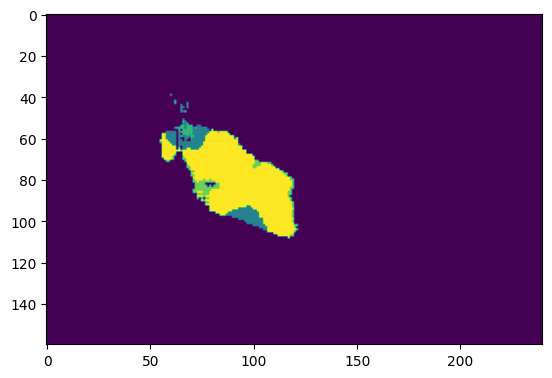

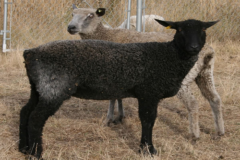

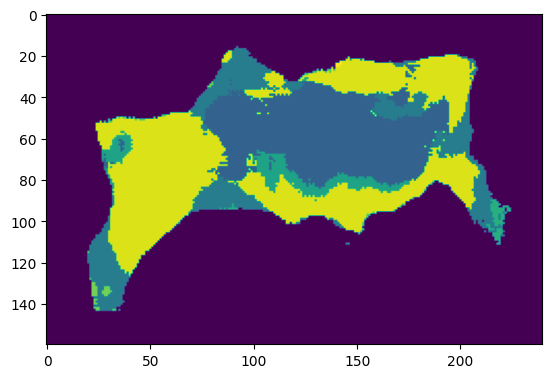

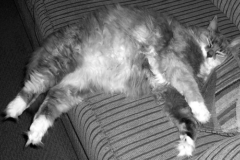

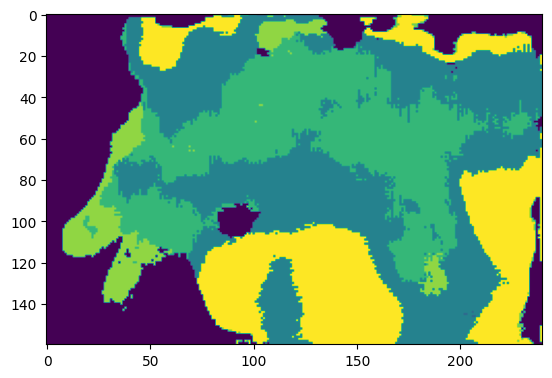

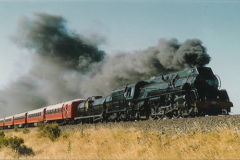

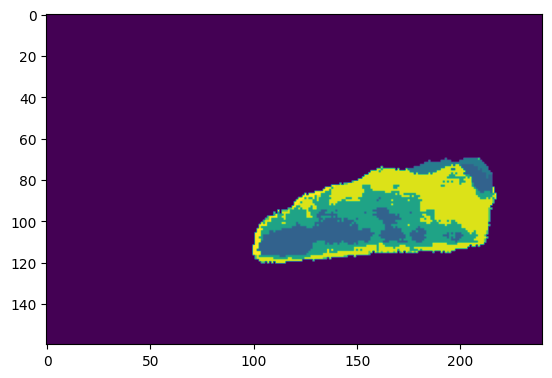

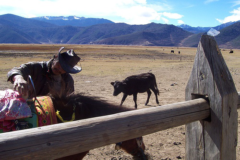

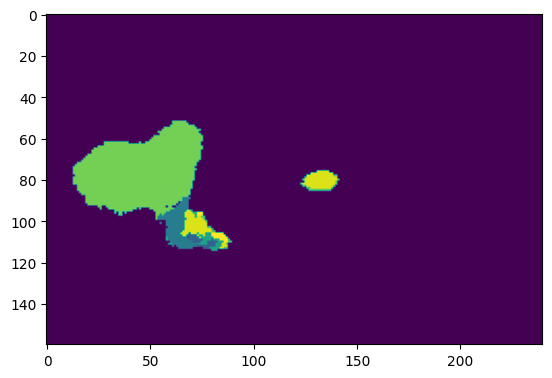

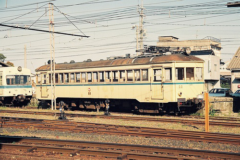

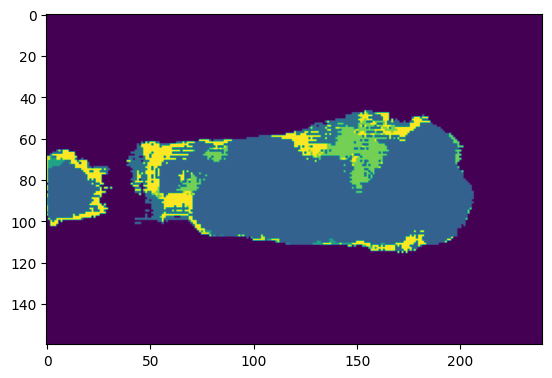

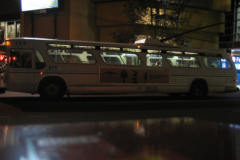

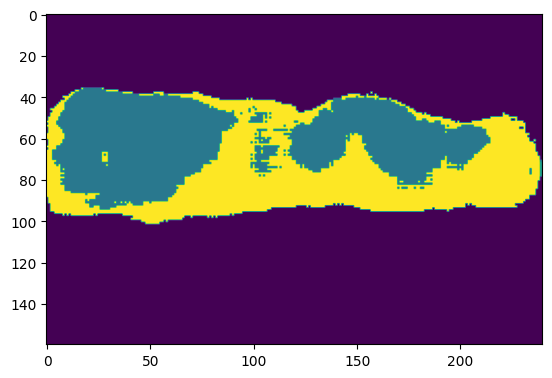

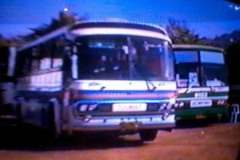

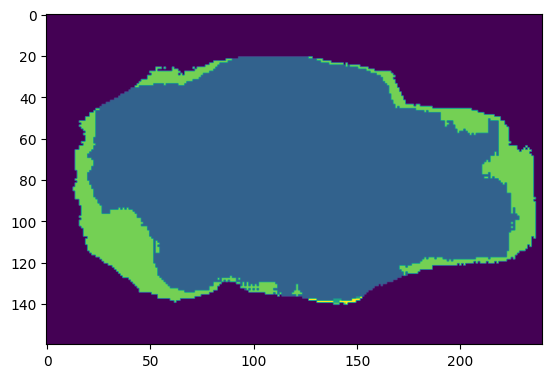

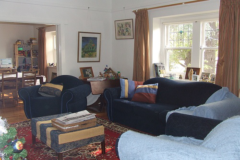

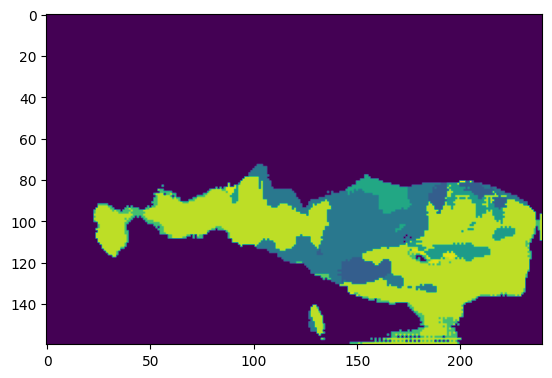

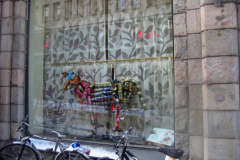

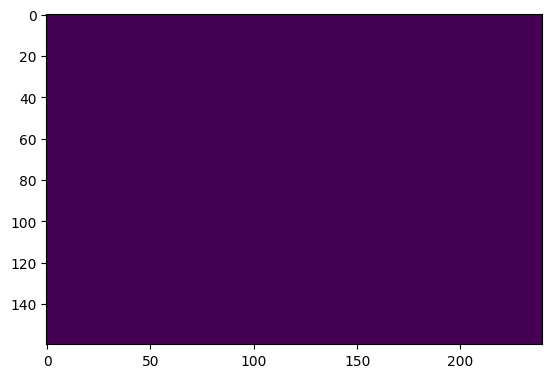

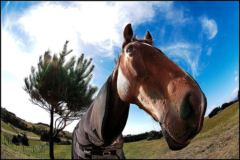

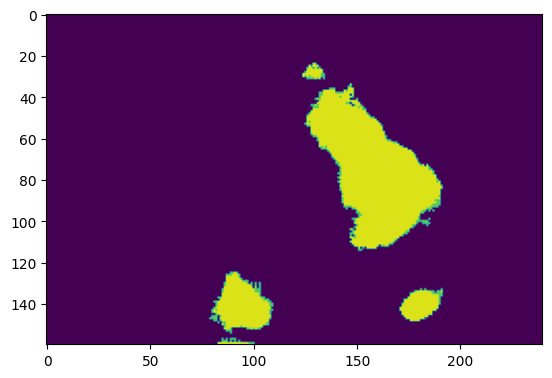

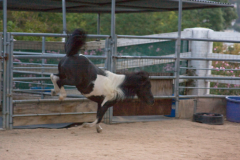

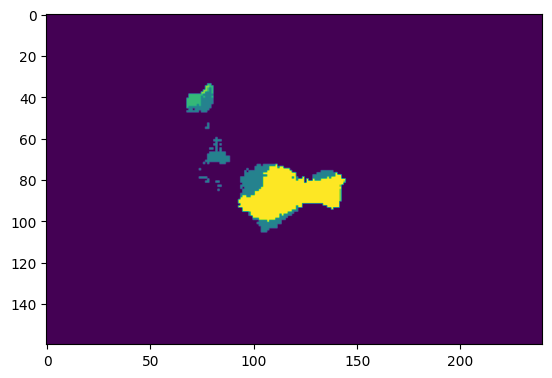

100%|██████████| 92/92 [00:07<00:00, 11.81it/s]


In [3]:
train_ds = SegmentationDataset()
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=12, pin_memory=True)
model = LightningUNet()
model = model.load_from_checkpoint('lightning_logs/version_11/checkpoints/epoch=99-step=9200.ckpt')

rand_idx = torch.randint(0, len(train_dl), (1,)).item()
train_epoch = tqdm(train_dl)
for batch_idx, batch in enumerate(train_epoch):
    if batch_idx == rand_idx:
        img, mask = batch
        logits = model(img)
        for i in range(len(img)):
            display(ToPILImage()(img[i]))
            plt.imshow(logits.argmax(dim=1)[i].cpu())
            plt.show()